# ModelNet40 HDF5 Point Cloud Visualization

Loads point clouds from the ModelNet40 HDF5 training shards listed in `train_files.txt`, maps labels to human-readable class names from `shape_names.txt`, and visualizes random samples.

Features:
- Efficient lazy loading of HDF5 shards.
- Random sampling across all shards.
- 3D scatter visualization (matplotlib) with per-class color map.
- Grid visualization of multiple classes.
- Simple class frequency summary.

Adjust the parameters in the configuration cell to control sample counts and output saving.

In [1]:
# Section 1: Imports & Configuration
import os, random, math, sys
from pathlib import Path
import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

ROOT = Path(os.getcwd()).resolve()
DATA_ROOT = ROOT / 'point_cloud_data' / 'modelnet40_ply_hdf5_2048'
TRAIN_LIST_FILE = DATA_ROOT / 'train_files.txt'
SHAPE_NAMES_FILE = DATA_ROOT / 'shape_names.txt'
OUTPUT_DIR = ROOT / 'evaluation_outputs'; OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Visualization parameters
NUM_RANDOM_SAMPLES = 12   # total random clouds to visualize individually
POINT_SIZE = 4
GRID_ROWS = 3
GRID_COLS = 4
FIG_SIZE_SINGLE = (4,4)
FIG_SIZE_GRID = (14,10)
SEED = 42
SAVE_FIGS = True

random.seed(SEED); np.random.seed(SEED)
print('Data root:', DATA_ROOT)

Data root: C:\Users\jakob\Documents\work\spatial-autoencoder\point_cloud_data\modelnet40_ply_hdf5_2048


In [2]:
# Section 2: Load File Lists & Shape Names
assert TRAIN_LIST_FILE.exists(), f'Missing train_files.txt at {TRAIN_LIST_FILE}'
with open(TRAIN_LIST_FILE, 'r') as f:
    train_files = [line.strip() for line in f if line.strip()]
# Paths inside txt are relative; resolve to absolute
train_paths = [ROOT / path for path in train_files]
print('Found', len(train_paths), 'HDF5 shards')
for p in train_paths: assert p.exists(), f'Missing shard: {p}'

assert SHAPE_NAMES_FILE.exists(), 'shape_names.txt missing'
with open(SHAPE_NAMES_FILE, 'r') as f:
    shape_names = [line.strip() for line in f if line.strip()]
print('Loaded', len(shape_names), 'shape names')
shape_id_to_name = {i: n for i, n in enumerate(shape_names)}

Found 5 HDF5 shards
Loaded 40 shape names


In [3]:
# Section 3: Index All Shards (counts & lazy access)
shard_metadata = []  # list of dicts: {'path': Path, 'count': int}
total_clouds = 0
for path in train_paths:
    with h5py.File(path, 'r') as h5f:
        data = h5f['data']  # (num, 2048, 3)
        labels = h5f['label']  # (num, 1)
        n = data.shape[0]
        shard_metadata.append({'path': path, 'count': n})
        total_clouds += n
print('Total clouds across shards:', total_clouds)

Total clouds across shards: 9840


In [4]:
# Section 4: Random Sampling Helper
def sample_global_indices(num_samples):
    # Uniform over all clouds
    chosen = np.random.choice(total_clouds, size=min(num_samples, total_clouds), replace=False)
    return chosen

# Build cumulative index mapping
cumulative = []  # (start, end, path)
cursor = 0
for meta in shard_metadata:
    start = cursor; end = cursor + meta['count']
    cumulative.append((start, end, meta['path']))
    cursor = end

def load_by_global_index(gidx):
    for start, end, path in cumulative:
        if start <= gidx < end:
            local_idx = gidx - start
            with h5py.File(path, 'r') as h5f:
                pts = h5f['data'][local_idx]  # (2048, 3)
                label = int(h5f['label'][local_idx][0])
            return pts, label, path.name, local_idx
    raise IndexError(gidx)

Saved figure to C:\Users\jakob\Documents\work\spatial-autoencoder\evaluation_outputs\modelnet40_random_grid.png


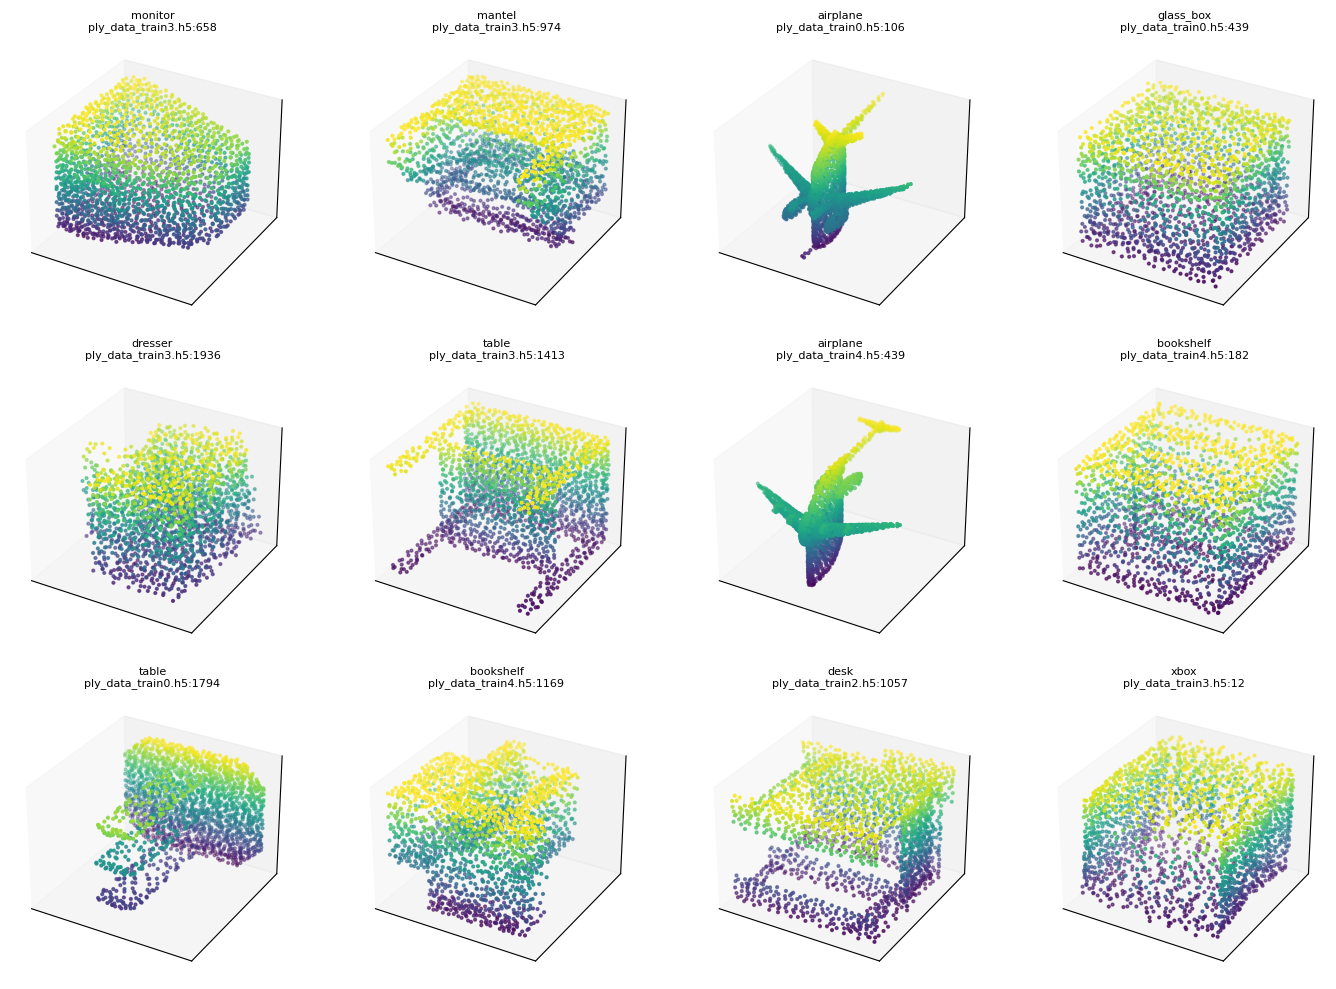

In [6]:
# Section 5: Visualize Random Single Samples
rand_indices = sample_global_indices(NUM_RANDOM_SAMPLES)
samples = [load_by_global_index(int(i)) for i in rand_indices]

def plot_point_cloud(ax, pts, title='', s=POINT_SIZE):
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=s, c=pts[:,2], cmap='viridis', depthshade=True)
    ax.set_title(title, fontsize=8)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

fig = plt.figure(figsize=(FIG_SIZE_GRID[0], FIG_SIZE_GRID[1]))
rows = GRID_ROWS; cols = GRID_COLS
for i, (pts, label, shard_name, local_idx) in enumerate(samples):
    if i >= rows*cols: break
    ax = fig.add_subplot(rows, cols, i+1, projection='3d')
    cls_name = shape_id_to_name.get(label, str(label))
    plot_point_cloud(ax, pts, title=f'{cls_name}\n{shard_name}:{local_idx}')
plt.tight_layout()
if SAVE_FIGS:
    out_path = OUTPUT_DIR / 'modelnet40_random_grid.png'
    plt.savefig(out_path, dpi=150)
    print('Saved figure to', out_path)
plt.show()

Total instances per top classes:
chair          : 889
sofa           : 680
airplane       : 625
bookshelf      : 572
bed            : 515
vase           : 475
monitor        : 465
table          : 392
toilet         : 344
bottle         : 335
Saved bar plot to C:\Users\jakob\Documents\work\spatial-autoencoder\evaluation_outputs\modelnet40_class_distribution.png


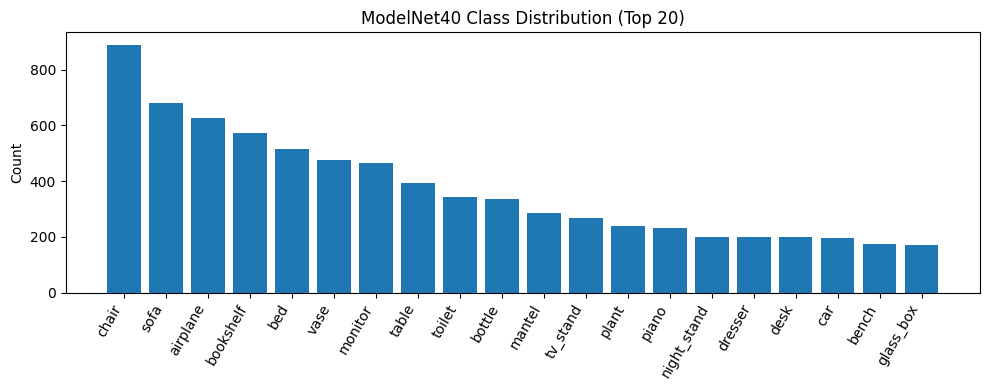

In [8]:
# Section 6: Class Frequency Summary (approx from sampled subset & shard-level counts)
# We'll gather all labels (may be large) cautiously; for full distribution we iterate all shards once.
label_counts = np.zeros(len(shape_names), dtype=int)
for meta in shard_metadata:
    # Open each shard and count labels
    with h5py.File(meta['path'], 'r') as h5f:
        labels = h5f['label'][:]  # shape (num, 1)
        for lbl in labels:
            label_counts[int(lbl[0])] += 1

topk = 10
sorted_idx = np.argsort(-label_counts)
print('Total instances per top classes:')
for i in range(topk):
    idx = sorted_idx[i]
    print(f'{shape_names[idx]:15s}: {label_counts[idx]}')

plt.figure(figsize=(10,4))
order = sorted_idx[:min(20, len(shape_names))]
plt.bar([shape_names[i] for i in order], label_counts[order])
plt.xticks(rotation=60, ha='right')
plt.ylabel('Count')
plt.title('ModelNet40 Class Distribution (Top 20)')
plt.tight_layout()
if SAVE_FIGS:
    out_bar = OUTPUT_DIR / 'modelnet40_class_distribution.png'
    plt.savefig(out_bar, dpi=150)
    print('Saved bar plot to', out_bar)
plt.show()

Saved figure to C:\Users\jakob\Documents\work\spatial-autoencoder\evaluation_outputs\chair_examples.png


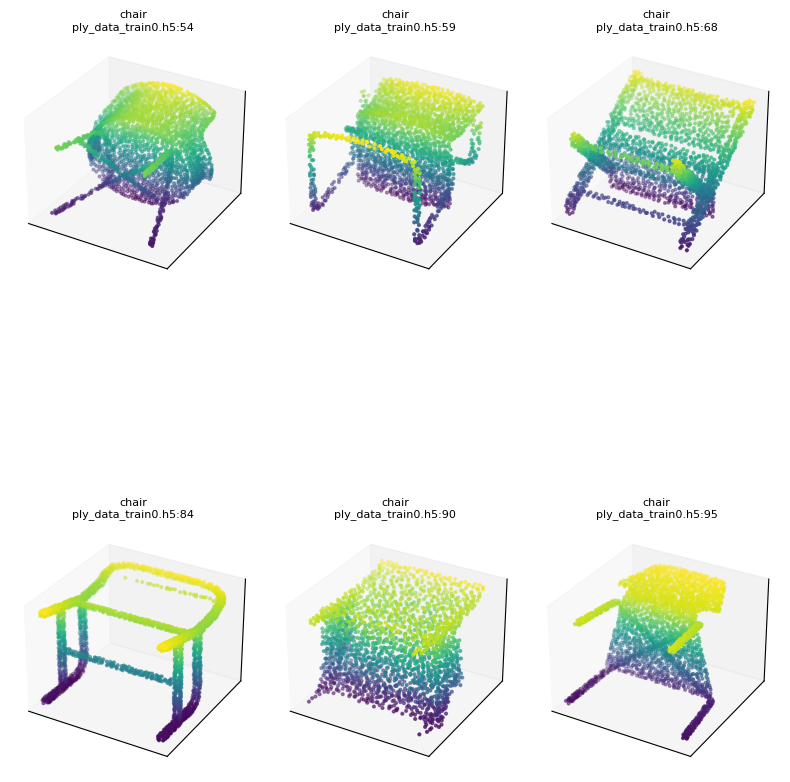

In [10]:
# Section 7: Inspect a Specific Class (first k examples)
TARGET_CLASS = 'chair'  # change to any shape name
MAX_EXAMPLES = 6
cls_idx = shape_names.index(TARGET_CLASS) if TARGET_CLASS in shape_names else None
if cls_idx is not None:
    collected = []
    for meta in shard_metadata:
        with h5py.File(meta['path'], 'r') as h5f:
            labels = h5f['label'][:]  # shape (num, 1)
            data = h5f['data'][:]     # shape (num, 2048, 3)
            for i, lbl in enumerate(labels):
                if int(lbl[0]) == cls_idx:
                    collected.append((data[i], meta['path'].name, i))
                    if len(collected) >= MAX_EXAMPLES:
                        break
        if len(collected) >= MAX_EXAMPLES:
            break
    if collected:
        fig = plt.figure(figsize=(FIG_SIZE_SINGLE[0]*2, FIG_SIZE_SINGLE[1]*math.ceil(MAX_EXAMPLES/2)))
        for idx, (pts, shard_name, local_idx) in enumerate(collected):
            ax = fig.add_subplot(2, math.ceil(MAX_EXAMPLES/2), idx+1, projection='3d')
            plot_point_cloud(ax, pts, title=f'{TARGET_CLASS}\n{shard_name}:{local_idx}')
        plt.tight_layout()
        if SAVE_FIGS:
            out_path = OUTPUT_DIR / f'{TARGET_CLASS}_examples.png'
            plt.savefig(out_path, dpi=150)
            print('Saved figure to', out_path)
        plt.show()
    else:
        print(f'No examples of class "{TARGET_CLASS}" found.')
else:
    print('TARGET_CLASS not in shape names list.')

## Next Steps
- Integrate autoencoder encoding to extract latents per class.
- Build similarity matrices between classes.
- Add interactive 3D visualization (e.g., Plotly) if desired.